In [1]:
import json, random, os
import matplotlib.pyplot as plt
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from tqdm.notebook import tqdm
from langchain_community.retrievers import BM25Retriever
from sentence_transformers import SentenceTransformer, util
from PIL import Image

DATA_DIR = "/mnt/data/factcheck/averimatec"
SPLIT = "val"

model = SentenceTransformer("clip-ViT-B-32", device="cuda")

# embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL, model_kwargs={"device": "cuda:0"})
random.seed(111)

with open(f"{DATA_DIR}/{SPLIT}.json") as f:
    datapoints = json.load(f)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
datapoints[2]

{'article': 'https://web.archive.org/web/20230629073625/https://leadstories.com/hoax-alert/2023/06/fact-check-photos-do-not-prove-hobby-lobby-is-selling-satanic-statues.html',
 'date': '2023-06-13',
 'label': 'Refuted',
 'location': 'US',
 'questions': [{'input_images': [],
   'answers': [{'answer_type': 'Extractive',
     'answer_text': 'Hobby Lobby Stores, Inc., formerly Hobby Lobby Creative Centers, is an American retail company. It owns a chain of arts and crafts stores with a volume of over $5 billion in 2018.',
     'source_url': 'https://en.wikipedia.org/wiki/Hobby_Lobby',
     'source_medium': 'Web text'}],
   'question': 'What is Hobby Lobby?',
   'answer_method': 'Text-search',
   'question_type': ['Text-related']},
  {'input_images': ['6787dee1e2f02e5f4981b14e#INPUT#1#0.jpg',
    '6787dee1e2f02e5f4981b14e#INPUT#1#1.jpg',
    '6787dee1e2f02e5f4981b14e#INPUT#1#2.jpg',
    '6787dee1e2f02e5f4981b14e#INPUT#1#3.jpg'],
   'answers': [{'answer_type': 'Abstractive',
     'answer_text

In [9]:
import os
from glob import glob


def generate_clip_embeddings(images_path, model):

    image_paths = glob(os.path.join(images_path, "**/*.jpg"), recursive=True)

    embeddings = []
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            embedding = model.encode(image)
            embeddings.append(embedding)
        except Exception as e:
            print(f"Error encoding image {img_path}: {e}")

    return embeddings, image_paths

In [ ]:
import faiss
import numpy as np


def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + ".paths", "w") as f:
        for img_path in image_paths:
            f.write(img_path + "\n")

    return index


In [13]:
for CLAIM_ID in tqdm(range(15,19)):# Naive version with \n concatenated url2texts:   
    # skip if f"{DATA_DIR}/data_store/vecstore/{SPLIT}/4k/{CLAIM_ID}" exists
    if os.path.exists(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}"):
        continue

    os.makedirs(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}")
    datapoint = datapoints[CLAIM_ID]
    claim = datapoint["claim_text"]
    # display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
    embeddings, image_paths = generate_clip_embeddings(
        f"{DATA_DIR}/knowledge_store/{SPLIT}/image_related/image_related_store_image_{SPLIT}/{CLAIM_ID}",model
    )
    index = create_faiss_index(embeddings, image_paths, f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index")
    #db = FAISS.from_documents(chunks_pruned, embeddings)
#    db.save_local(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}")

  0%|          | 0/4 [00:00<?, ?it/s]

The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Error encoding image /mnt/data/factcheck/averimatec/knowledge_store/val/image_related/image_related_store_image_val/17/127.jpg: mean must have 1 elements if it is an iterable, got 3
Index created and saved to /mnt/data/factcheck/averimatec/vector_store/val/image/17/faiss.index
Index created and saved to /mnt/data/factcheck/averimatec/vector_store/val/image/18/faiss.index


In [15]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    # query preprocess:
    if query.endswith(
        (".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".gif", ".webp")
    ):  # Check if the query is an image file
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [16]:
import matplotlib.pyplot as plt


def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis("off")
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha="center", va="center")
        plt.axis("off")
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis("off")

    plt.show()

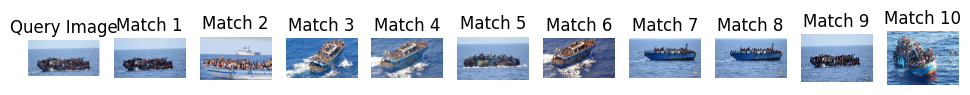

In [36]:
CLAIM_ID = 25
datapoint = datapoints[CLAIM_ID]
claim_image_filename = datapoint['claim_images'][0]
query_image_path = os.path.join(DATA_DIR, "images", claim_image_filename)

index_path = f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index"
index = faiss.read_index(index_path)

with open(index_path + ".paths", "r") as f:
    image_paths = [line.strip() for line in f]

query, retrieved_images = retrieve_similar_images(query_image_path, model, index, image_paths, top_k=10)
visualize_results(query, retrieved_images)

In [ ]:
# scroll thru previous CLAIM_IDs
for CLAIM_ID in range(15,19):
    datapoint = datapoints[CLAIM_ID]
    claim = datapoint["claim_text"]
    print(f"### 🗯️ {claim} [{datapoint['label']}]")
    index_path = f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index"
    index = faiss.read_index(index_path)

    with open(index_path + ".paths", "r") as f:
        image_paths = [line.strip() for line in f]

    query, retrieved_images = retrieve_similar_images(claim, model, index, image_paths, top_k=3)
    visualize_results(query, retrieved_images)